# Price Sensitivity Analsis
## multi-arm contextual bandit

The following simulation is inplemented with JAX. Developed by Google, Jax is a Python library that is specifically designed for ML research. Unlike Tensorflow and PyTorch, it is built with the functional programming (FP) paradigm, making it highly composable and promoting the concept of pure functions that have no side effects. This means that all state changes, such as parameter updates or splitting of random generators, must be done explicitly. Although this may require more lines of code than their object-oriented programming (OOP) equivalent, it gives developers full control over state changes, leading to increased understanding of the code and fewer surprises.

In [1]:
import jax
import numpy as np

# Low level operators
from jax import lax

# API for working with pseudorandom number generators
from jax import random

# Numpy API with hardware acceleration and automatic differentiation
from jax import numpy as jnp

# Creates a function that evaluates the gradient of fun.
from jax import grad

import Logit_JAX as lrj

import PriceSensitivity_Utils as ps

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Random seed to make our experiment replicable 
SEED = 142

# Number of visitors we want to simulate
NUM_VISITS = 1000

# Possible prices which can be offered to client
PRICE_LIST = jnp.arange(0,1,0.01)
# Featurs differentiating client groups of different price sensitivity
FEATURE_SPACE = jnp.asarray([jnp.asarray([0,1]), jnp.asarray([1,0])], dtype=jnp.float32)
# Price Sensitivity Parameters for Client Groups, these parameters are applied to the price-sensitivity curve
PRICE_SENSITIVITY_PARMS = [[3,-0.1], [3,-0.3]]

### Price Sensitivity Model

The following curves the probability of closing a deal ($\mathbb{P}(sale) \in (0,1)$) for two cleint groups (orange and blue) for a price range between 0 and 1.

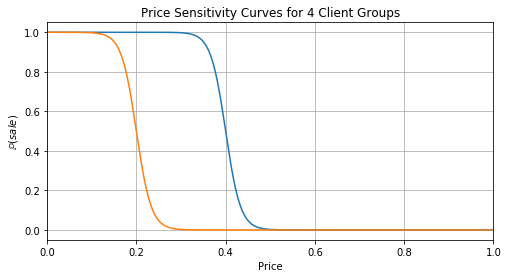

In [3]:
FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1]))

plt.plot(r, ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[1][0], PRICE_SENSITIVITY_PARMS[1][1]))

#plt.plot(r, ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[2][0], PRICE_SENSITIVITY_PARMS[2][1]))

#plt.plot(r, ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[3][0], PRICE_SENSITIVITY_PARMS[3][1]))
ax.grid()
_ = ax.set(xlabel="Price", ylabel="$\mathbb{P}(sale)$", title="Price Sensitivity Curves for 4 Client Groups")
_ = ax.set_xlim(0, 1)

### Optimal Price

The price with the highest expected return $$ max \mathbb{E}[reward] = argmax_{price} (price* \mathbb{P}(sale))$$

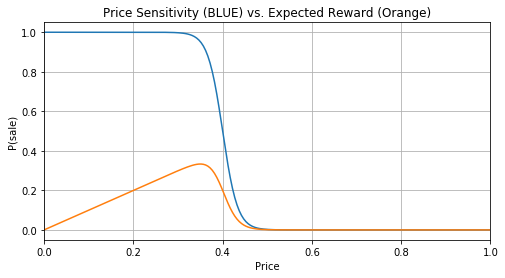

In [4]:
FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1]))

plt.plot(r, r*ps.price_sensitivity_curve(r, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1]))

ax.grid()
_ = ax.set(xlabel="Price", ylabel="P(sale)", title="Price Sensitivity (BLUE) vs. Expected Reward (Orange)")
_ = ax.set_xlim(0, 1)

In [5]:
def append_feature_space(X, sold, price):
    X = jnp.append(jnp.asarray(X), jnp.expand_dims(jnp.asarray(price), axis=0), axis=0)
    y = sold
    return X, y

def append_feature_space_crossover_learning(X, sold, price, price_list):
    # return prices above 'price'
    def range_above(price):
        return jnp.where(price_list >= price, 1, 0)
    
    # return prices below 'price'
    def range_below(price):
        return jnp.where(price_list <= price, 1, 0)
    
    price_ind = lax.cond(sold,range_below,range_above,price)
    price_range = price_ind*price_list
    #price_range = jnp.unique(price_range)
    
    # duplicate y for entire price range 
    y = jnp.tile(sold, (price_list.shape[0], 1))
    ####incorrect price 0 must be true
    y = y*jnp.array(price_ind, dtype=bool)
    
    # duplicate feature space and append price range into feature space
    X = jnp.tile(X, (price_range.shape[0], 1))
    X = jnp.append(jnp.asarray(X), jnp.expand_dims(jnp.asarray(price_range), axis=1), axis=1)
    return X, y 

In [6]:
def visit(state, timestep, feature_list, price_list, price_sensitivity_params, policy_fn, update_fn):
    """
    Simulates a user visit.
    """

    # Unpacking the experiment state into
    # the agent's parameters and the random number generator
    params, rng = state

    # Splitting the random number generator
    next_rng, client_group_rng, policy_rng, user_rng = random.split(rng, num=4)

    # simulate client type
    client_type = jnp.asarray(random.randint(client_group_rng, shape=[1], minval = 0, maxval = feature_list.shape[0]))[0]
    
    # Selecting the variant to show the user, based on
    # the given policy, the agent's paramters, and the current timestep
    price = policy_fn(params, feature_list[client_type], client_type, price_sensitivity_params[client_type], price_list, timestep, policy_rng)

    # Randomly simulating a purchase, based on
    # a Bernoulli Random variable where the parameter
    # p is obtained from the price sensitivity curve above
    p_tmp = ps.price_sensitivity_curve(price, price_sensitivity_params[client_type][0], price_sensitivity_params[client_type][1])
    sold = jnp.asarray(jax.random.bernoulli(user_rng, p=p_tmp, shape=None))

    # appending prices to feature space
    X, y = append_feature_space(feature_list[client_type], sold, price)
    #X, y = append_feature_space_crossover_learning(feature_list[client_type], sold, price, price_list)
    # Calculating the agent's updated parameters, based on
    # the current parameters, the selected variant,
    # and whether or not the user clicked
    next_params = update_fn(params, X, y)
    # Returning the updated experiment state (params and rng) and
    # whether or not the user clicked
    return (next_params, next_rng), (price, sold)  

## Implementing the policies

In [7]:
def reward(price):
    # turnover/profit genrated from sale
    return price

In [8]:
def epsilon_greedy_policy(params, features, client_type, price_sensitivity_params, price_list, timestep, rng, epsilon = 0.1):
    """
    Randomly selects either the variant with highest action-value,
    or an arbitrary variant.
    """

    # Selecting a random variant
    def explore(params, features, price_list, rng):
        i = random.choice(rng, jnp.arange(len(price_list)))
        return price_list[i]
    
        # Selecting the variant with the highest action-value estimate
    def exploit(params, features, price_list, rng):
        # maximum expected reward
        X = jnp.tile(features, (price_list.shape[0], 1))
        X = jnp.append(jnp.asarray(X), jnp.expand_dims(jnp.asarray(price_list), axis=1), axis=1)
        exp_reward = lrj.predict_proba(params['c'],params['w'], X)*reward(price_list)
        argmax = price_list[jnp.argmax(exp_reward)]
        return argmax

    
    # Splitting the random number generator 
    uniform_rng, choice_rng = random.split(rng)
    
    # Deciding randomly whether to explore or to exploit
    return lax.cond(
        random.uniform(uniform_rng) < epsilon,
        explore,
        exploit,
        params, 
        features, 
        price_list,
        choice_rng
    )

In [9]:
def optimal_policy(params, features, client_type, price_sensitivity_params, price_list, timestep, rng):
    """
    Policy always selects price with max expected return
    """
    
    exp_reward = ps.price_sensitivity_curve(price_list, price_sensitivity_params[0], price_sensitivity_params[1])*reward(price_list)
    price = price_list[jnp.argmax(exp_reward)]
    
    return price

In [ ]:
def ninety_perc_optimal_policy(params, features, client_type, price_sensitivity_params, price_list, timestep, rng):
    """
    Policy always selects price with max expected return
    """
    
    probabilites = ps.price_sensitivity_curve(price_list, price_sensitivity_params[0], price_sensitivity_params[1])
    
    price = price_list[jnp.argmax(probabilites)]
    
    return price

## Implementing the evaluation

In [10]:
from functools import partial
from matplotlib import pyplot as plt

In [11]:
def evaluate(policy_fn, init_fn, update_fn):
    """
    Simulating the experiment for NUM_VISITS users
    while accumulating the click history
    """

    return lax.scan(
        # Compiling the visit function using just-in-time (JIT) compilation
        # for better performance
        jax.jit(
            # Partially applying the visit function by fixing
            # the price list, feature space, price sensitivity, policy_fn, and update_fn parameters 
            partial(
                visit,
                feature_list=jnp.array(FEATURE_SPACE),
                price_list=jnp.array(PRICE_LIST),
                price_sensitivity_params=jnp.array(PRICE_SENSITIVITY_PARMS),
                policy_fn=jax.jit(policy_fn),
                update_fn=jax.jit(update_fn)
            )
        ),
        
        # Initialising the experiment state using
        # init_fn and a new PRNG key
        (init_fn(len(FEATURE_SPACE[0])), random.PRNGKey(SEED)),
        
        # Setting the number steps of the experiment
        jnp.arange(1, NUM_VISITS + 1)
    )

In [12]:
def reward_evolution(history):
    """
    Calculates the regret for every action in the experiment history
    """

    # Calculating regret with regard to picking the optimal (0.045) variant
    def fn(acc, reward):
        n, v = acc[0] + 1, acc[1] + reward
        return (n, v), (v / n)
    
    # Calculating regret values over entire history
    _, result = lax.scan(
        jax.jit(fn),
        (jnp.array(0), jnp.array(0)),
        history[0]*history[1]
    )
    
    return result

In [13]:
# Epsilon greedy policy
(epsilon_greedy_params, _), epsilon_greedy_history = evaluate(
    policy_fn=partial(epsilon_greedy_policy, epsilon=0.1),
    init_fn=lrj.params_init,
    update_fn=partial(lrj.logit_update, eta=0.01)
)

# Optimal policy
(optimal_params, _), optimal_history = evaluate(
    policy_fn=partial(optimal_policy),
    init_fn=lrj.params_init,
    update_fn=partial(lrj.logit_update, eta=0.01)
)

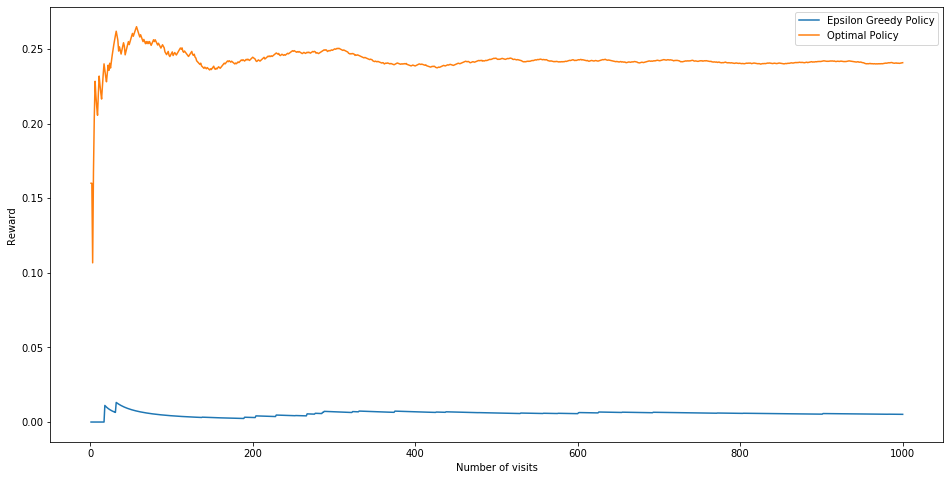

In [15]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = jnp.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of visits')
ax.set_ylabel('Reward')

ax.plot(x, reward_evolution(epsilon_greedy_history), label='Eps Greedy Logit')
ax.plot(x, reward_evolution(optimal_history), label='Optimal Policy')

plt.legend()
plt.show()